In [457]:
# Importing libraries
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.draw import line
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.filters import sobel
from skimage import exposure
from skimage.restoration import denoise_bilateral
from skimage.feature import canny
from skimage import color
from skimage.feature import ORB, SIFT, BRIEF
from skimage.feature import match_descriptors
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.measure import ransac
from skimage.registration import phase_cross_correlation
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import warp, AffineTransform, rotate, resize
from skimage.morphology import binary_dilation, binary_erosion
from __future__ import print_function
import cv2
from PIL import Image, ImageFilter

In [447]:
def binarize_image(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    binary = exposure.equalize_adapthist(binary, clip_limit=0.03)
    return binary

# display the image
def show_image(image, title='Image', cmap_type='gray'):
    plt.figure(figsize = (10, 15))
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# binarize and enhance the image    
def preprocess(image_list, rescale=False, binarize=True,
              new_scan=True, exemplar=False):
    return_list = []
    for img in image_list:
        if new_scan:
            # crop the hand writing and denoise
            ydim, xdim = img.shape
            box_width = 900
            box_height = 600
            if exemplar:
                img = img.astype(bool)
                img[:,:300] = colorize_image(img[:,:300],[255,255,255])[:,:,1]
                img[:,xdim-300:xdim] = colorize_image(img[:,xdim-300:xdim],[255,255,255])[:,:,1]
                pic_grayscale_cropped = img.astype(int)
            else:
                img[ydim-box_height:ydim,xdim-box_width:xdim] = colorize_image(img[ydim-box_height:ydim, 
                                                                                              xdim-box_width:xdim],
                                                                  [255,255,255])[:,:,1]
                pic_grayscale_cropped = img[:,100:xdim].astype(int)
        else:
            pic_grayscale = color.rgb2gray(img)
            ruler_length = 159
            ydim, xdim = pic_grayscale.shape[0], pic_grayscale.shape[1]
            pic_grayscale_cropped = pic_grayscale[ruler_length:ydim-ruler_length, 
                                                  ruler_length:xdim-ruler_length]
        if rescale:
            height = ydim/2
            width = xdim/2
            pic_grayscale_cropped = resize(pic_grayscale_cropped, 
                                   (height, width), 
                                   anti_aliasing=True)
        if binarize:
            binary = binarize_image(pic_grayscale_cropped)
        else:
            binary = pic_grayscale_cropped
        return_list.append(binary)
    return return_list

# save the image
def save_image(img, name):
    I = img
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

    img = Image.fromarray(I8)
    img.save(name)
    
# color the pixels
def colorize_image(img, color_code):
    if len(img.shape) == 2:
        img = color.gray2rgb(img)
    height, width, _ = img.shape
    for i in range(height):
        for j in range(width):
            if img[i, j, 0] < 0.5:
                img[i, j] = color_code
            else:
                img[i, j] = [255,255,255]
    return img

In [338]:
# Importing the reference (model) and moving (data) images
# Make sure to convert the imgages to type int or bool not float
img_model_org = np.array(Image.open('Shoe04R-2-154.6-M3.png'))
img_data_org = np.array(Image.open('Shoe03R-2-211.4-M2.png'))

In [458]:
# preprocess images
processed_images = preprocess([img_model_org, img_data_org], 
                              rescale=False, binarize=False)
img_model, img_data = processed_images[0], processed_images[1]


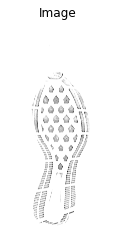

In [340]:
img_model_colorized = color.gray2rgb(img_model.astype(int))
for i in range(img_model.shape[0]):
    for j in range(img_model.shape[1]):
        if img_model[i,j] == 1:
            img_model_colorized[i,j] = [255,255,255]
        else:
            img_model_colorized[i,j] = [0,0,0]
show_image(img_model_colorized)

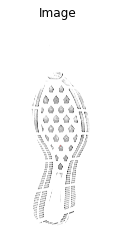

In [341]:
# Find centroid
y,x = centroid_coord
for i in range(y-10, y+10):
    for j in range(x-10, x+10):
        img_model_colorized[i, j] = [255, 0, 0]
show_image(img_model_colorized)

In [87]:
# Pixel intensity
img_1 = np.array(Image.open('gray_scale/Shoe03R_1_143.3_M1.jpg'))
img_2 = np.array(Image.open('gray_scale/Shoe03R_1_170.4_M1.jpg'))
img_3 = np.array(Image.open('gray_scale/Shoe03R_1_182.3_M1.jpg'))
img_4 = np.array(Image.open('gray_scale/Shoe03R_1_205.5_M1.jpg'))

In [93]:
# preprocess images
processed_images = preprocess([img_1, img_2, img_3, img_4], 
                              rescale=False, binarize=False)
img_1_processed, img_2_processed, img_3_processed, img_4_processed = processed_images[0], processed_images[1], processed_images[2], processed_images[3]

Average pixel density: 252.83244321475627
Total number of dark pixels: 199415


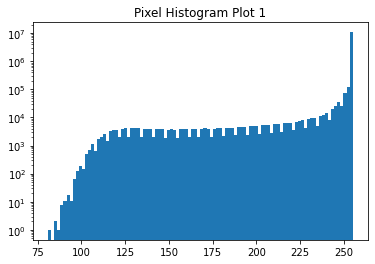

Average pixel density: 251.99700070267897
Total number of dark pixels: 275861


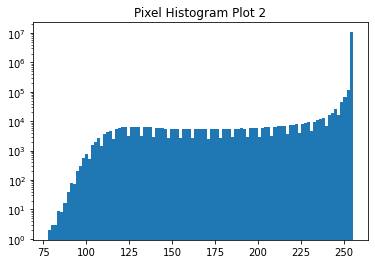

Average pixel density: 251.33589117259552
Total number of dark pixels: 334460


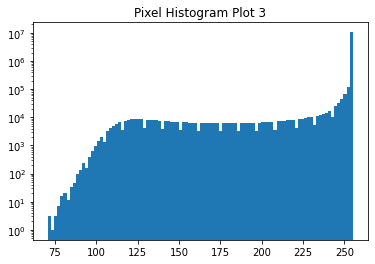

Average pixel density: 251.3255370223979
Total number of dark pixels: 341228


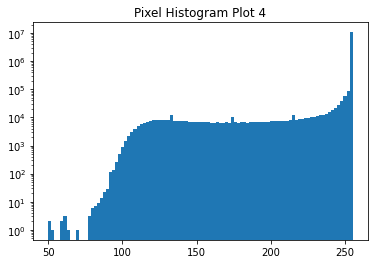

In [127]:
i = 1
for img in processed_images:
    img = img.flatten()
    thresh = threshold_otsu(img)
    print('Average pixel density: ' + str(np.mean(img)))
    print('Total number of dark pixels: ' + str(np.count_nonzero(img < thresh)))
    plt.hist(img, bins = 100, log = True)
    plt.title('Pixel Histogram Plot ' + str(i))
    plt.show()
    i+=1

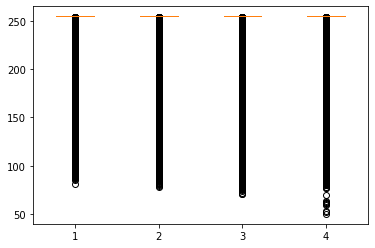

In [126]:
plt.boxplot([img_1.flatten(), img_2.flatten(), img_3.flatten(), img_4.flatten()])
plt.show()

In [459]:
# Edge detection
img_model = np.array(Image.open('Shoe04R-2-154.6-M3.png'))
img_data = np.array(Image.open('Shoe04R-2-216.1-M3.png'))

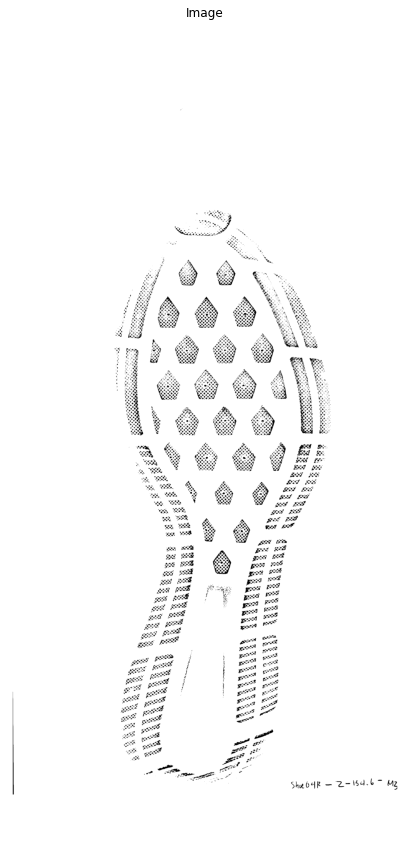

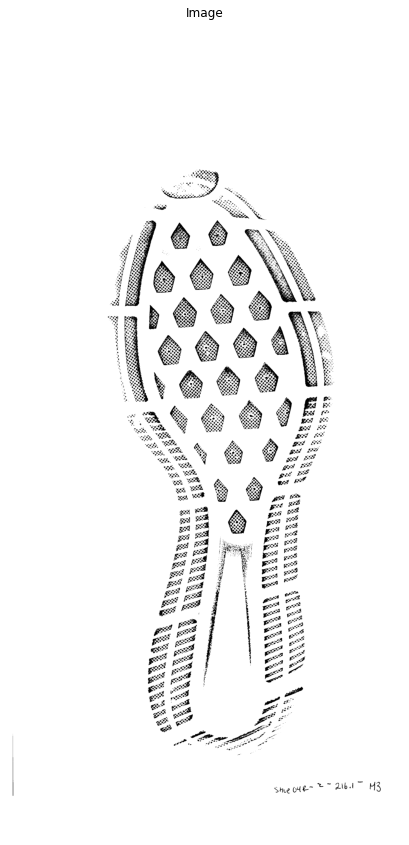

In [460]:
show_image(img_model)
show_image(img_data)

In [422]:
# Area detection
def area_detect(img, width=200, height=40):
    # preprocess image
    img = preprocess([img], rescale=False, binarize=False)[0]
    img = (1-img).astype(bool)
    # find image centroid
    black_coords = np.where(img == False)
    length = len(black_coords[0])
    sum_x = np.sum(black_coords[0])
    sum_y = np.sum(black_coords[1])
    centroid_coord = np.around([sum_x/length, sum_y/length]).astype(int)
    # find the left edge
    y_bound = img.shape[0]
    x_bound = centroid_coord[1]
    edge_coord_left = []
    count = 0
    row = 0
    while (row < y_bound):
        for col in range(x_bound):
            cur_pixel = img[row, col]
            if cur_pixel:
                if edge_coord_left:
                    last_x = edge_coord_left[-1][1]
                    if col in range(last_x-width, last_x+width):
                        edge_coord_left.append([row, col])
                else:
                    edge_coord_left.append([row, col])
                break
        row += height
    # find the right edge
    edge_coord_right = []
    row = 0
    while (row < y_bound):
        col = img.shape[1]-1
        while (col >= x_bound):
            cur_pixel = img[row, col]
            if cur_pixel:
                if edge_coord_right:
                    last_x = edge_coord_right[-1][1]
                    if col in range(last_x-width, last_x+width):
                        edge_coord_right.append([row, col])
                else:
                    edge_coord_right.append([row, col])
                break
            col -= 1
        row += height
    edge_coord = np.concatenate((np.array(edge_coord_left), np.flip(edge_coord_right, 0)))
    temp_edge = np.full(img.shape, False)
    # connect the pixels
    for coord in edge_coord:
        temp_edge[coord[0], coord[1]] = True
    for i in range(len(edge_coord)-1):
        y1,x1 = edge_coord[i]
        y2,x2 = edge_coord[i+1]
        rr, cc = line(y1, x1, y2, x2)
        temp_edge[rr, cc] = True
    y1,x1 = edge_coord[0]
    y2,x2 = edge_coord[-1]
    rr, cc = line(y1, x1, y2, x2)
    temp_edge[rr, cc] = True
    # fill in the internal area
    edges = sobel(temp_edge)
    fill_img = ndi.binary_fill_holes(edges)
    return fill_img

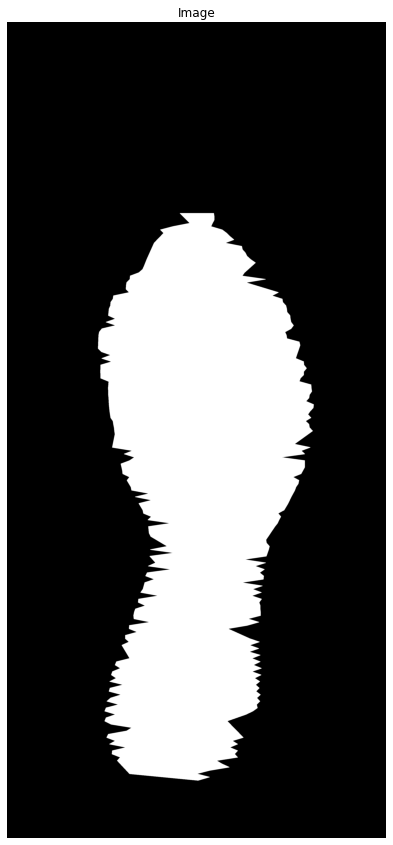

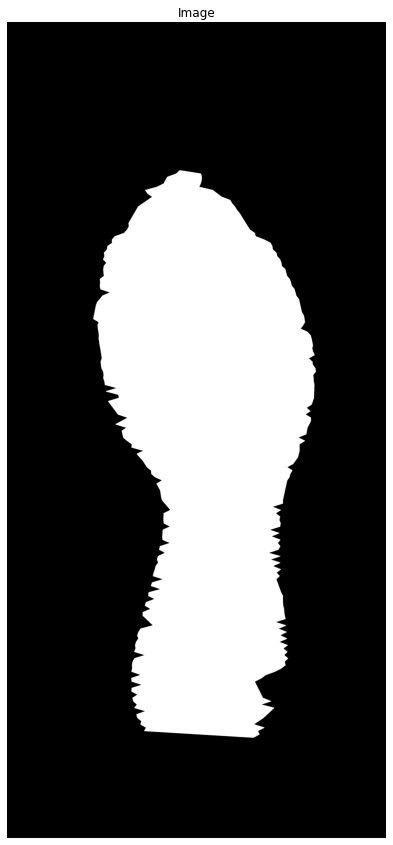

In [479]:
img_model_area = area_detect(img_model, height=20, width=150)
img_data_area = area_detect(img_data, height=20, width=90)
show_image(img_model_area)
show_image(img_data_area)

In [480]:
img_model_area_opt = Image.fromarray(img_model_area)
img_model_area_opt = img_model_area_opt.filter(ImageFilter.ModeFilter(size=120))

img_data_area_opt = Image.fromarray(img_data_area)
img_data_area_opt = img_data_area_opt.filter(ImageFilter.ModeFilter(size=120))

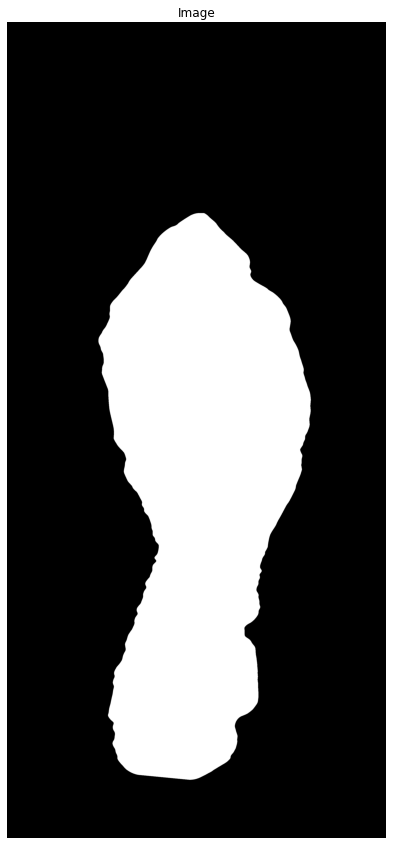

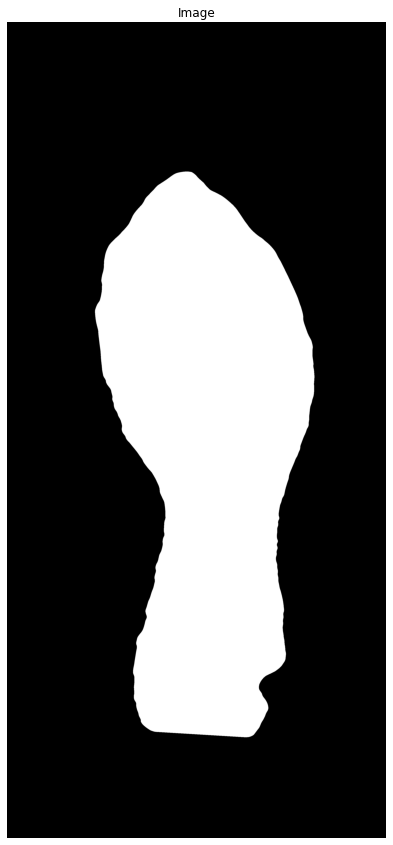

In [481]:
show_image(img_model_area_opt)
show_image(img_data_area_opt)

In [1085]:
no_weight = np.array(img_model_area_opt)
max_weight = np.array(img_data_area_opt)
print(np.unique(no_weight, return_counts=True))
np.unique(max_weight, return_counts=True)

(array([False,  True]), array([8449378, 2935622]))


(array([False,  True]), array([8299619, 3085381]))

In [1086]:
3085381/2935622*100

105.10144017179324

In [674]:
save_image(img_model_area.astype(int), "Aligned Images/Shoe04R-2-154.6-M3-area.png")
save_image(np.array(img_model_area_opt).astype(int), "Aligned Images/Shoe04R-2-154.6-M3-area-opt.png")
save_image(img_data_area.astype(int), "Aligned Images/Shoe04R-2-216.1-M3-area.png")
save_image(np.array(img_data_area_opt).astype(int), "Aligned Images/Shoe04R-2-216.1-M3-area-opt.png")

In [683]:
# Testing new algorithm for edge detection
img = np.array(Image.open('Shoe04R-2-154.6-M3.png'))
img = preprocess([img], rescale=False, binarize=False)[0]

In [486]:
black_coords = np.where(img == False)
length = len(black_coords[0])
sum_x = np.sum(black_coords[0])
sum_y = np.sum(black_coords[1])
centroid_coord = np.around([sum_x/length, sum_y/length]).astype(int)
centroid_coord

array([2465, 1148])

In [441]:
np.unique(img_data_area, return_counts=True)

(array([False,  True]), array([8294448, 3090552]))

In [391]:
width = 150
height = 20
y_bound = img.shape[0]
x_bound = centroid_coord[1]
edge_coord_left = []
count = 0
row = 0
while (row < y_bound):
    for col in range(x_bound):
        cur_pixel = img[row, col]
        if cur_pixel:
            if edge_coord_left:
                last_x = edge_coord_left[-1][1]
                if col in range(last_x-width, last_x+width):
                    edge_coord_left.append([row, col])
            else:
                edge_coord_left.append([row, col])
            break
    row += height

In [657]:
width = 50
height = 20
height_skip = 50
y_bound = img.shape[0]
x_bound = centroid_coord[1]
edge_coord_left = []
count = 0
row = 0
removed = False
while (row < y_bound):
    for col in range(x_bound):
        if img[row, col]:
            if edge_coord_left and (height == 100):
                last_x = edge_coord_left[-1][1]
                if col in range(last_x-width, last_x+width):
                    edge_coord_left.append([row, col])
            else:
                edge_coord_left.append([row, col])
            
            break
    height = 50
    for row_temp in range(row+1, row+height_skip):
        if row_temp < img.shape[0] and img[row_temp, col]:
            height = abs(row_temp-row)
            break
#     print(row, col, height)
    row += height

In [658]:
edge_coord_right = []
width = 50
height = 20
row = 0
while (row < y_bound):
    col = img.shape[1]-1
    while (col >= x_bound):
        if img[row, col]:
            if edge_coord_right and (height == 100):
                last_x = edge_coord_right[-1][1]
                if col in range(last_x-width, last_x+width):
                    edge_coord_right.append([row, col])
            else:
                edge_coord_right.append([row, col])
            break
        col -= 1
    height = 100
    for row_temp in range(row+1, row+height_skip):
        if row_temp < img.shape[0] and img[row_temp, col]:
            height = abs(row_temp-row)
            break
#     print(row, col, height)
    row += height

In [666]:
removed_index = []
i = 0
while(i < len(edge_coord_left)-1):
    last_x = i
    while(i < len(edge_coord_left)-1 and abs(edge_coord_left[last_x][1]-edge_coord_left[i+1][1]) >= 140):
        removed_index.append(i+1)
        i += 1
    i += 1
edge_coord_left = np.array(edge_coord_left)
edge_coord_left = np.delete(edge_coord_left, removed_index, axis = 0)

In [668]:
edge_coord = np.concatenate((np.array(edge_coord_left), np.flip(edge_coord_right, 0)))
temp_edge = np.full(fill_img.shape, False)
for coord in edge_coord:
    temp_edge[coord[0], coord[1]] = True
# save_image(temp_edge.astype(int), "temp_edge_all.png")

In [669]:
for i in range(len(edge_coord)-1):
    y1,x1 = edge_coord[i]
    y2,x2 = edge_coord[i+1]
    rr, cc = line(y1, x1, y2, x2)
    temp_edge[rr, cc] = True
y1,x1 = edge_coord[0]
y2,x2 = edge_coord[-1]
rr, cc = line(y1, x1, y2, x2)
temp_edge[rr, cc] = True
# save_image(temp_edge.astype(int), "temp_edge_lined_all.png")

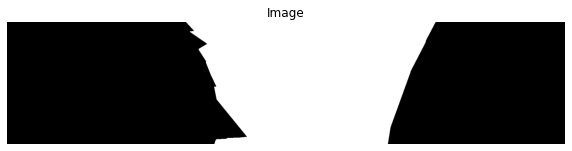

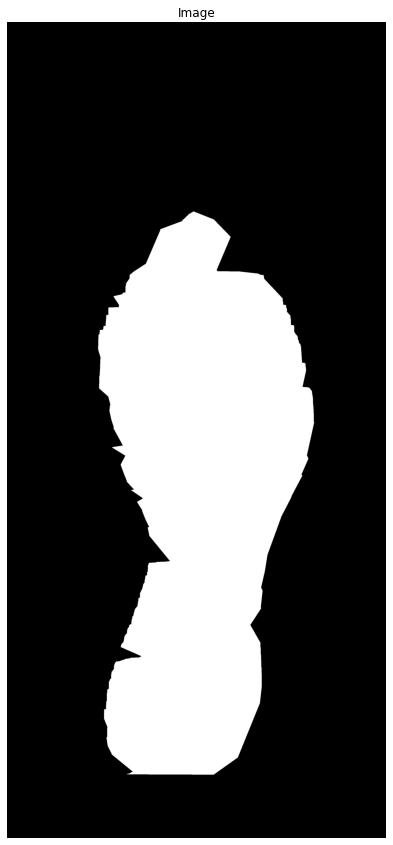

In [670]:
edges = sobel(temp_edge)
fill_img = ndi.binary_fill_holes(edges)
show_image(fill_img[2800:3300,:])
show_image(fill_img)
# save_image(fill_img.astype(int), "Shoe04R-2-154.6-M3-area.png")

In [1189]:
# GRID PIXEL COMPARISON
img_model = Image.open('pixel_density/Shoe01R-2-150.0-M2-model.png')
img_data = Image.open('pixel_density/Shoe01R-2-211.4.0-M2-transformed.png')

In [1190]:
aligned_img = Image.blend(img_model, img_data, 0.5)
aligned_img.save("pixel_density/shoe01_M2_150v211.png", "PNG")
aligned_img = np.array(aligned_img)

In [1197]:
height, width = aligned_img.shape
first_pixel = False
left_bound = []
row = 0
increment = 1
check = False
while (row < height):
    for col in range(width):
        if not first_pixel:
            if aligned_img[row, col] < 200:
                left_bound.append(row-50)
                first_pixel = True
                increment = 300
                break
        else:
            mean_pixel_row = np.mean(aligned_img[row])
            if mean_pixel_row > 253:
                temp_row = row
                while(row < height and 
                      np.mean(aligned_img[row]) > 252.5):
                    row+=1
                increment = 300
                left_bound.append(round(np.mean([temp_row, row])))
            else:
                increment = 1
            break
    row += increment

In [1198]:
left_bound

[492, 921, 1272, 1614, 1990, 2316, 2634, 2956, 3266, 3579, 3946, 4599]

In [1199]:
row = height-1
last_pixel = False
while(not last_pixel):
    for col in range(width):
        if aligned_img[row, col] < 200:
            last_pixel = True
            left_bound[-1] = row+50
            break
    row -= 1

In [1200]:
left_bound[2] -= 30
left_bound[4] += 30
for i in range(5,10):
    left_bound[i] -= 50
left_bound[5] -= 30

In [1201]:
lined_img = np.copy(aligned_img)
for i in range(len(left_bound)):
    lined_img[left_bound[i]] = np.full((1, width), 0)
    if np.mean([np.mean(aligned_img[row]) for row in left_bound[i:len(left_bound)]]) == 255.0:
        break

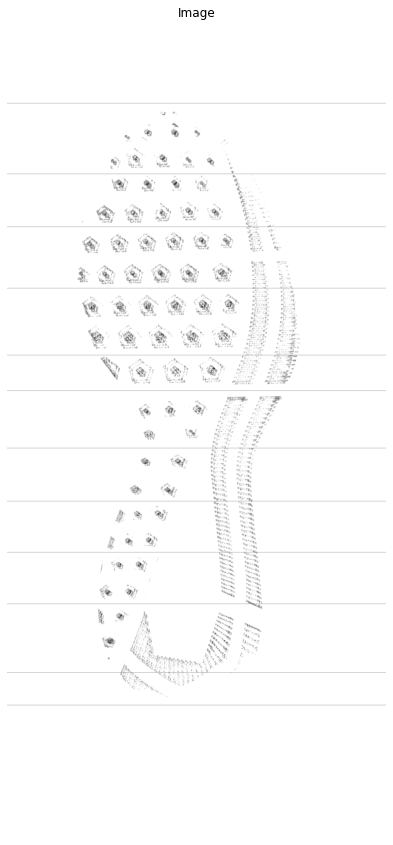

In [1202]:
show_image(lined_img)

In [1203]:
# Get the pixel density difference
def get_pixel_diff(img1, img2):
    thresh1 = threshold_otsu(img1)
    thresh2 = threshold_otsu(img2)
    img1 = img1.flatten()
    img2 = img2.flatten()
    avg_density_diff = (np.mean(img1) - np.mean(img2))/np.mean(img1)
    black_pixel_count_diff = np.count_nonzero(img2 < thresh2) - np.count_nonzero(img1 < thresh1)
    return [avg_density_diff, black_pixel_count_diff]

def get_misaligned_pixels(img1, img2, thresh1, thresh2):
    img1 = img1 > thresh1
    img2 = img2 > thresh2
    count = 0
    x_bound, y_bound = img1.shape[1], img1.shape[0]
    for i in range(y_bound):
        for j in range(x_bound):
            if img1[i,j] ^ img2[i,j]:
                count += 1
    return count

In [1204]:
img1 = np.array(img_model)
img2 = np.array(img_data)

length = len(left_bound)
diff_vec = np.full((length-1), 0.000000)

for i in range(length-1):
    row1 = left_bound[i]
    row2 = left_bound[i+1]
    
    diff_vec[i] = get_pixel_diff(img1[row1:row2, :],
                                 img2[row1:row2, :])[0]

In [1205]:
color_map = np.full((height, width), 0.000000)
for i in range(length-1):
    row1 = left_bound[i]
    row2 = left_bound[i+1]
    color_map[row1:row2, :] = np.full((row2-row1, width), diff_vec[i])
    print(diff_vec[i])

0.0009501770461851059
0.0037530807563883853
0.0067389543435068125
0.008247007548479419
0.006739064288179854
0.00608975076815112
0.0049678979941209294
0.004797918717083618
0.0026824365636305744
0.006324661870842908
0.0026321257794927775


In [1212]:
fig = plt.figure(figsize=(10, 10), dpi = 1500)
max_abs = np.max(np.abs(color_map))
plt.axis('off')
plot = plt.imshow(color_map, cmap = 'bwr', interpolation = 'nearest', vmin = -max_abs, vmax = max_abs)
plt.colorbar(plot)
# plt.savefig('pixel_density/shoe01_M2_heatmap.png', 
#              format='png', dpi=1500, bbox_inches='tight', pad_inches=0)

In [1171]:
# Export pixel density df
weight = [143.6, 170.7, 183.2, 205]
vec140 = []
vec170 = []
vec183 = []
vec205 = []

In [1170]:
# Apply for multiple images
import glob
noweight_images = []
noweight_features_vec = []
for filename in glob.glob('mid_weight/*.png'):
    print(filename)
#     img = np.array(Image.open(filename))
#     img = preprocess([img], rescale=False, binarize=False)[0]
#     save_image(img, filename)

mid_weight/14.png
mid_weight/01.png
mid_weight/15.png
mid_weight/03.png
mid_weight/17.png
mid_weight/16.png
mid_weight/02.png
mid_weight/12.png
mid_weight/13.png
mid_weight/11.png
mid_weight/05.png
mid_weight/04.png
mid_weight/10.png
mid_weight/09.png
mid_weight/20.png
mid_weight/18.png
mid_weight/19.png


In [1172]:
# Apply for multiple images
import glob
noweight_images = []
noweight_features_vec = []
for filename in glob.glob('no_weight/*.png'):
    print(filename)
    img = np.array(Image.open(filename))
    img_flat = img.flatten()
    vec140.append(img_flat.mean())

no_weight/14.png
no_weight/01.png
no_weight/15.png
no_weight/03.png
no_weight/17.png
no_weight/16.png
no_weight/02.png
no_weight/12.png
no_weight/13.png
no_weight/11.png
no_weight/05.png
no_weight/04.png
no_weight/10.png
no_weight/09.png
no_weight/20.png
no_weight/18.png
no_weight/19.png


In [1173]:
for filename in glob.glob('max_weight/*.png'):
    print(filename)
    img = np.array(Image.open(filename))
    img_flat = img.flatten()
    vec205.append(img_flat.mean())

max_weight/14.png
max_weight/01.png
max_weight/15.png
max_weight/03.png
max_weight/17.png
max_weight/16.png
max_weight/02.png
max_weight/12.png
max_weight/13.png
max_weight/11.png
max_weight/05.png
max_weight/04.png
max_weight/10.png
max_weight/09.png
max_weight/20.png
max_weight/18.png
max_weight/19.png


In [1174]:
for filename in glob.glob('mid_weight/*.png'):
    print(filename)
    img = np.array(Image.open(filename))
    img_flat = img.flatten()
    vec170.append(img_flat.mean())

mid_weight/14.png
mid_weight/01.png
mid_weight/15.png
mid_weight/03.png
mid_weight/17.png
mid_weight/16.png
mid_weight/02.png
mid_weight/12.png
mid_weight/13.png
mid_weight/11.png
mid_weight/05.png
mid_weight/04.png
mid_weight/10.png
mid_weight/09.png
mid_weight/20.png
mid_weight/18.png
mid_weight/19.png


In [1175]:
for filename in glob.glob('up_mid_weight/*.png'):
    print(filename)
    img = np.array(Image.open(filename))
    img_flat = img.flatten()
    vec183.append(img_flat.mean())

up_mid_weight/14.png
up_mid_weight/01.png
up_mid_weight/15.png
up_mid_weight/03.png
up_mid_weight/17.png
up_mid_weight/16.png
up_mid_weight/02.png
up_mid_weight/12.png
up_mid_weight/13.png
up_mid_weight/11.png
up_mid_weight/05.png
up_mid_weight/04.png
up_mid_weight/10.png
up_mid_weight/09.png
up_mid_weight/20.png
up_mid_weight/18.png
up_mid_weight/19.png


In [1181]:
df1 = np.concatenate([vec140, vec170, vec183, vec205])
df2 = np.concatenate([[weight[0]]*17, [weight[1]]*17, 
                      [weight[2]]*17, [weight[3]]*17])
data = {'Intensity': df1, 'Weight': df2}
df = pd.DataFrame(data)
df.to_csv('intensity_weight.csv', index=False)